# DIVAnd analysis using the sample data set

This example performs a salinity analysis using data from the Black Sea.     
The analysis is performed for every season and year (using all data with 10-year sliding windows form the same season).

For testing purposes, let's start with a low resolution.

A slightly large test case:
* [ ] horizontal resolution of 0.1 degree for the Black Sea
* [ ] 51 depths levels
* [ ] time instance
* [ ] fixed correlation length
* [ ] CPU time: 21 minutes
* [ ] CPU time increases linearly with the number of time instance.

In [1]:
using DIVAnd
using Makie, CairoMakie, GeoMakie
using NCDatasets
using DataStructures
using Dates
using Statistics
include("../config.jl")

[ Info: Precompiling DIVAnd [efc8151c-67de-5a8f-9a35-d8f54746ae9d] (cache misses: incompatible header (8), dep missing source (4))
[ Info: Precompiling Makie [ee78f7c6-11fb-53f2-987a-cfe4a2b5a57a] (cache misses: wrong dep version loaded (14), incompatible header (4))
[ Info: Precompiling SciMLBaseMakieExt [565f26a4-c902-5eae-92ad-e10714a9d9de] (cache misses: wrong dep version loaded (10), incompatible header (8))
[ Info: Precompiling CairoMakie [13f3f980-e62b-5c42-98c6-ff1f3baf88f0] (cache misses: wrong dep version loaded (12), incompatible header (6))
[ Info: Precompiling GeoMakie [db073c08-6b98-4ee5-b6a4-5efafb3259c6] (cache misses: wrong dep version loaded (14), incompatible header (4))


"https://dox.uliege.be/index.php/s/h8d3pyqmuea6J9H/download"

## Read data
### Observations
Download the file `Salinity.bigfile` (if it is not already present). It will be placed in the same directory as this notebook.      
This file is based on the World Ocean Database.

In [2]:
fname = salinitybigfile
download_check(fname, salinitybigfileURL)

[ Info: File already downloaded


The observations are stored in a simple text file with the following columns:

| longitude | latitude | value | depth | flag | year | month | day | hour | time string | identifier | bottom depth |
|----------:|---------:|------:|------:|-------:|------:|-----:|-----|------:|-------:|-------:|-------:|
| 28.3333 | 43.167 | 15.7020 | 0.0 | 0 | 1991 | 09 | 03 | 16 | 1991-09-03T16:25 | Cruise:WOD05_BG000003-11570900-28.3333-43.167 | 36 | 
| 28.3333 | 43.167 | 15.7380 | 10.0 | 0 | 1991 | 09 | 03 | 16 | 1991-09-03T16:25 | Cruise:WOD05_BG000003-11570900-28.3333-43.167 | 36 |

The longitude, latitude, depth, time, values and identifiers are used.

In [3]:
obsval, obslon, obslat, obsdepth, obstime, obsid = loadbigfile(fname);
@show size(obsval);

[ Info: Loading data from 'big file' ../data/Salinity.bigfile


size(obsval) = (139230,)


We perform some string manipulations to the observation IDs, to ensure the format is working.

In [4]:
obsid_mod =
    [join((split(replace(split(oo, ":")[2], "_" => "-"), "-")[1:3]), "-") for oo in obsid];
@show(obsid_mod[1:5]);

obsid_mod[1:5] = ["WOD05-BG000003-11570900", "WOD05-BG000003-11570900", "WOD05-BG000003-11570900", "WOD05-BG000003-11570900", "WOD05-BG000003-11570901"]


The file contains about 140000 measurements.     
Let's print some basic statistics about the data, keeping an eye on the ranges.

In [5]:
checkobs((obslon, obslat, obsdepth, obstime), obsval, obsid)

[ Info: Checking ranges for dimensions and observations


              minimum and maximum of obs. dimension 1: (27.1005, 41.65)
              minimum and maximum of obs. dimension 2: (40.517, 47.272)
              minimum and maximum of obs. dimension 3: (0.0, 2000.0)
              minimum and maximum of obs. dimension 4: (DateTime("1977-03-27T04:00:00"), DateTime("2006-12-15T09:52:00"))
                          minimum and maximum of data: (0.0, 38.6573)


### Bathymetry
Download the bathymetry if it is not already present

In [6]:
bathname = gebco16file
download_check(gebco16file, gebco16fileURL)
bathisglobal = true

[ Info: File already downloaded


true

## Analysis setting
### Grid parameters
Define the resolution. It is recommended to start with a low resolution and increase the resolution when the results are suitable.

In [7]:
dx = 0.2 # longitude resolution in degrees
dy = 0.2 # latitude resolution in degrees

0.2

Define the bounding box of the spatial domain

In [8]:
lonr = 27.0:dx:42.0; # the range of longitudes (start:step:end)
latr = 40.0:dy:47.0; # the range of latitudes (start:step:end)

Define the depth levels

In [9]:
depthr = [0.,5., 10., 15., 20., 25., 30., 40., 50., 66, 
    75, 85, 100, 112, 125, 135, 150, 175, 200, 225, 250, 
    275, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 
    800, 850, 900, 950, 1000, 1050, 1100, 1150, 1200, 1250, 
    1300, 1350, 1400, 1450, 1500, 1600, 1750, 1850, 2000]

# or for testing just a few levels
depthr = [0.,20.,50.]

@show size(depthr);

size(depthr) = (3,)


We extract the bathymetry and the mask for plotting:

In [10]:
bx, by, b = extract_bath(bathname, bathisglobal, lonr, latr);
_, _, mask = load_mask(bathname, bathisglobal, lonr, latr, 0)

(27.0:0.2:42.0, 40.0:0.2:47.0, Bool[0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0])

### Analysis parameters
The error variance of the observation (scaled by the error variance of the background).    
Note that this is the inverse of the signal-to-noise ratio used in the 2D version of `DIVA`.

In [11]:
epsilon2 = 0.01;

* Correlation length in meters (in x, y, and z directions)
* 200_000. is the same as 200000., but the former is easier to read.

In [12]:
sz = (length(lonr), length(latr), length(depthr))

lenx = fill(200_000.0, sz)
leny = fill(200_000.0, sz)
lenz = [10 + depthr[k] / 15 for i = 1:sz[1], j = 1:sz[2], k = 1:sz[3]];

### Time periods
The analysis is performed using a 10-year window.

In [13]:
years = 1993:1994

year_window = 10

# winter: January-March    1,2,3
# spring: April-June       4,5,6
# summer: July-September   7,8,9
# autumn: October-December 10,11,12

monthlists = [[1, 2, 3], [4, 5, 6], [7, 8, 9], [10, 11, 12]];

* Other possible choises for the time selector are `TimeSelectorYearListMonthList` and `TimeSelectorRunningAverage`.
* Type `?` followed by these functions

In [14]:
?TimeSelectorYW

search: TimeSelectorYW



```
TS = TimeSelectorYW(years,yearwindow,monthlists)
```

The structure `TS` handles the time aggregation based on `years` and `monthlists`. It is similar to `TimeSelectorYearListMonthList` except that the elements of `yearlists` are centred around `years` and span `yearwindow` years. `yearlists` is in fact constructed by adding and subtracting `yearwindow/2` to every element of years.


In [15]:
TS = TimeSelectorYW(years, year_window, monthlists)

TimeSelectorYearListMonthList{Vector{StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}}, Vector{Vector{Int64}}}(StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}[1988.0:1.0:1998.0, 1989.0:1.0:1999.0], [[1, 2, 3], [4, 5, 6], [7, 8, 9], [10, 11, 12]])

There are four monthly periods (on per season) and 2 years, leading to a total of 8 time periods for the analysis.


In [16]:
@info("Workong on $(length(TS)) time periods");

[ Info: Workong on 8 time periods


### Other parameters
Let's define the variable name, the file name and the time origin.

In [17]:
varname = "Salinity"

# File name based on the variable (but all spaces are replaced by _)
filename = "Water_body_$(replace(varname, " "=>"_")).4Danl.nc"

# Time origin for the NetCDF file
timeorigin = DateTime(1900, 1, 1, 0, 0, 0)

1900-01-01T00:00:00

### Metadata 
The metadata are essential when one is ready to publish their product(s), since metadata contain all the relevant information concerning how the products were prepared and by who.
#### List of all metadata

In [18]:
metadata = OrderedDict(
    # Name of the project (SeaDataCloud, SeaDataNet, EMODNET-chemistry, ...)
    "project" => "SeaDataCloud",

    # URN code for the institution EDMO registry,
    # e.g. SDN:EDMO::1579
    "institution_urn" => "SDN:EDMO::1579",

    # Production group
    #"production" => "Diva group",

    # Name and emails from authors
    "Author_e-mail" =>
        ["Your Name1 <name1@example.com>", "Other Name <name2@example.com>"],

    # Source of the observation
    "source" => "observational data from SeaDataNet/EMODNet Chemistry Data Network",

    # Additional comment
    "comment" => "...",

    # SeaDataNet Vocabulary P35 URN
    # http://seadatanet.maris2.nl/v_bodc_vocab_v2/search.asp?lib=p35
    # example: SDN:P35::WATERTEMP
    "parameter_keyword_urn" => "SDN:P35::EPC00001",

    # List of SeaDataNet Parameter Discovery Vocabulary P02 URNs
    # http://seadatanet.maris2.nl/v_bodc_vocab_v2/search.asp?lib=p02
    # example: ["SDN:P02::TEMP"]
    "search_keywords_urn" => ["SDN:P02::PSAL"],

    # List of SeaDataNet Vocabulary C19 area URNs
    # SeaVoX salt and fresh water body gazetteer (C19)
    # http://seadatanet.maris2.nl/v_bodc_vocab_v2/search.asp?lib=C19
    # example: ["SDN:C19::3_1"]
    "area_keywords_urn" => ["SDN:C19::3_3"],
    "product_version" => "1.0",
    "product_code" => "something-to-decide",

    # bathymetry source acknowledgement
    # see, e.g.
    # * EMODnet Bathymetry Consortium (2016): EMODnet Digital Bathymetry (DTM).
    # https://doi.org/10.12770/c7b53704-999d-4721-b1a3-04ec60c87238
    # 
    # taken from
    # http://www.emodnet-bathymetry.eu/data-products/acknowledgement-in-publications
    #
    # * The GEBCO Digital Atlas published by the British Oceanographic Data Centre on behalf of IOC and IHO, 2003
    #
    # taken from
    # https://www.bodc.ac.uk/projects/data_management/international/gebco/gebco_digital_atlas/copyright_and_attribution/

    "bathymetry_source" => "The GEBCO Digital Atlas published by the British Oceanographic Data Centre on behalf of IOC and IHO, 2003",

    # NetCDF CF standard name
    # http://cfconventions.org/Data/cf-standard-names/current/build/cf-standard-name-table.html
    # example "standard_name" = "sea_water_temperature",
    "netcdf_standard_name" => "sea_water_salinity",
    "netcdf_long_name" => "sea water salinity",
    "netcdf_units" => "1e-3",

    # Abstract for the product
    "abstract" => "...",

    # This option provides a place to acknowledge various types of support for the
    # project that produced the data
    "acknowledgement" => "...",
    "documentation" => "https://doi.org/doi_of_doc",

    # Digital Object Identifier of the data product
    "doi" => "...",
)

OrderedDict{String, Any} with 18 entries:
  "project"               => "SeaDataCloud"
  "institution_urn"       => "SDN:EDMO::1579"
  "Author_e-mail"         => ["Your Name1 <name1@example.com>", "Other Name <na…
  "source"                => "observational data from SeaDataNet/EMODNet Chemis…
  "comment"               => "..."
  "parameter_keyword_urn" => "SDN:P35::EPC00001"
  "search_keywords_urn"   => ["SDN:P02::PSAL"]
  "area_keywords_urn"     => ["SDN:C19::3_3"]
  "product_version"       => "1.0"
  "product_code"          => "something-to-decide"
  "bathymetry_source"     => "The GEBCO Digital Atlas published by the British …
  "netcdf_standard_name"  => "sea_water_salinity"
  "netcdf_long_name"      => "sea water salinity"
  "netcdf_units"          => "1e-3"
  "abstract"              => "..."
  "acknowledgement"       => "..."
  "documentation"         => "https://doi.org/doi_of_doc"
  "doi"                   => "..."

* Make the NetCDF global and variable attributes based on the metadata.
* Custom attributes can be added by changing `ncglobalattrib`:

```julia
ncglobalattrib["attribute_name"] = "attribute_value"
```


In [19]:
pathname = joinpath(dirname(@__FILE__), "..")

const PROJECTS = Dict(
    "EMODNET-chemistry" => Dict(
        "name" => "EMODnet Chemistry",
        "URL" => "https://emodnet.ec.europa.eu/en/chemistry",
        "baseurl_visualization" => "http://ec.oceanbrowser.net/emodnet/",
        "baseurl_wms" => "http://ec.oceanbrowser.net/emodnet/Python/web/wms",
        "baseurl_http" => "http://ec.oceanbrowser.net/data/emodnet-domains",
        "baseurl_opendap" => "http://opendap.oceanbrowser.net/thredds/dodsC/data/emodnet-domains",
        "template" => joinpath(pathname, "templates", "emodnet-chemistry.mustache"),
    ),
    "SeaDataNet" => Dict(
        "name" => "SeaDataNet",
        "URL" => "http://www.seadatanet.org/",
        "baseurl_visualization" => "http://sdn.oceanbrowser.net/web-vis/",
        "baseurl_wms" => "http://sdn.oceanbrowser.net/web-vis/Python/web/wms",
        "baseurl_http" => "http://sdn.oceanbrowser.net/data/SeaDataNet-domains",
        "baseurl_opendap" => "http://opendap.oceanbrowser.net/thredds/dodsC/data/SeaDataNet-domains",
        "template" => joinpath(pathname, "templates", "seadatanet.mustache"),
    ),
    "SeaDataCloud" => Dict(
        "name" => "SeaDataCloud",
        "URL" => "http://www.seadatanet.org/",
        "baseurl_visualization" => "http://sdn.oceanbrowser.net/web-vis/",
        "baseurl_wms" => "http://sdn.oceanbrowser.net/web-vis/Python/web/wms",
        "baseurl_http" => "http://sdn.oceanbrowser.net/data/SeaDataCloud-domains",
        "baseurl_opendap" => "http://opendap.oceanbrowser.net/thredds/dodsC/data/SeaDataNet-domains",
        "template" => joinpath(pathname, "templates", "seadatanet.mustache"),
    ),
)

const OriginatorEDMO_URL = "https://emodnet-chemistry.maris.nl/download/export.zip"


const layersep = "*"

"*"

Whenever possible, we make use of the [Seadatanet controled vocabulary](https://www.seadatanet.org/Standards/Common-Vocabularies). 

<div class="alert alert-block alert-warning"> 
⚠️ The next steps require an internet connection in order to obtain information from the vocabulary server.
</div>

In [20]:
sdn_parameter_urn = metadata["parameter_keyword_urn"]
sdn_parameter = Vocab.resolve(sdn_parameter_urn)
sdn_parameter_name = Vocab.prefLabel(sdn_parameter)
sdn_uom = Vocab.findfirst(sdn_parameter, "related", "P06")
sdn_uom_urn = Vocab.urn(sdn_uom)
sdn_uom_name = Vocab.prefLabel(sdn_uom)


# derived attributes
project = PROJECTS[metadata["project"]]
ncglobalattrib = OrderedDict{String,String}();

OrderedDict{String, String}()

Finally, the function [`SDNMetadata`](https://gher-uliege.github.io/DIVAnd.jl/stable/#DIVAnd.SDNMetadata) creates the dictionary containing the global and variable attributes to be used in the netCDF storing the results.

In [21]:
ncglobalattrib, ncvarattrib = SDNMetadata(metadata, filename, varname, lonr, latr)

(OrderedDict("project" => "SeaDataCloud", "institution" => "University of Liège, GeoHydrodynamics and Environment Research", "institution_urn" => "SDN:EDMO::1579", "Author_e-mail" => "Your Name1 <name1@example.com>, Other Name <name2@example.com>", "source" => "observational data from SeaDataNet/EMODNet Chemistry Data Network", "comment" => "...", "parameter_keyword" => "Water body salinity", "parameter_keyword_urn" => "SDN:P35::EPC00001", "search_keywords" => "Salinity of the water column", "search_keywords_urn" => "SDN:P02::PSAL"…), OrderedDict("units" => "1e-3", "standard_name" => "sea_water_salinity", "long_name" => "sea water salinity"))

### Plots
Plot the results near the surface for debugging and quick inspection.

To generate the plots, we define a function `plotres` (see next cell) that will be used as an optional argument when we call the interpolation with `DIVAnd`.

In [22]:
function plotres(timeindex, sel, fit, erri)
    tmp = copy(fit)
    tmp[erri.>0.5] .= NaN

    fig = Figure(size = (600, 400))

    # select the data near the surface
    selsurface = (obsdepth .< 5)
    vmin, vmax = quantile(obsval[selsurface], (0.01, 0.99))

    # plot the data
    ga1 = GeoAxis(fig[1, 1]; dest = "+proj=merc", title = "Observations ($(timeindex))")
    heatmap!(ga1, lonr, latr, mask, colormap = Reverse(:binary))
    sc = scatter!(
        ga1,
        obslon[selsurface],
        obslat[selsurface],
        color = obsval[selsurface],
        markersize = 5,
        colorrange = [vmin, vmax],
    )

    xlims!(ga1, (lonr[1], lonr[end]))
    ylims!(ga1, (latr[1], latr[end]))
    Colorbar(fig[2, 1], sc, vertical = false)

    # plot the analysis
    ga2 = GeoAxis(fig[1, 2]; dest = "+proj=merc", title = "Analysis ($(timeindex))")
    heatmap!(ga2, lonr, latr, mask, colormap = Reverse(:binary))
    hm = heatmap!(
        ga2,
        lonr,
        latr,
        tmp[:, :, 1],
        interpolate = false,
        colorrange = [vmin, vmax],
    )

    xlims!(ga2, (lonr[1], lonr[end]))
    ylims!(ga2, (latr[1], latr[end]))
    Colorbar(fig[2, 2], hm, vertical = false)

    display(fig)

end

plotres (generic function with 1 method)

If you do not want to generate plots but print the time index at every time slice,       
you can use the function `plotres_timeindex`.

In [23]:
function plotres_timeindex(timeindex, sel, fit, erri)
    @show timeindex
end

plotres_timeindex (generic function with 1 method)

## Run analysis
Here we use [`diva3d`](https://gher-uliege.github.io/DIVAnd.jl/stable/#DIVAnd.diva3d), which performs a series of 3D analyses (lon, lat and depth) for the different periods defined previously.

<div class="alert alert-block alert-info"> 
🛈 Plotting can be disabled by commenting the line containing `plotres`, or by re-defining the function `plotres`.
</div>

[ Info: Creating netCDF file Water_body_Salinity.4Danl.nc
[ Info: Time step 1 / 8
[ Info: scaled correlation length (min,max) in dimension 1: (200000.0, 200000.0)
[ Info: scaled correlation length (min,max) in dimension 2: (200000.0, 200000.0)
[ Info: scaled correlation length (min,max) in dimension 3: (10.0, 13.333333333333334)
┌ Warning: resolution (20.0) is too coarse for correlation length 10.0 in dimension 3 at indices CartesianIndex(4, 3, 1) (skipping further tests). It is recommended that the resolution is at least 2 times finer than the correlation length.
└ @ DIVAnd ~/.julia/packages/DIVAnd/4UymR/src/utils.jl:18
[ Info: number of windows: 1


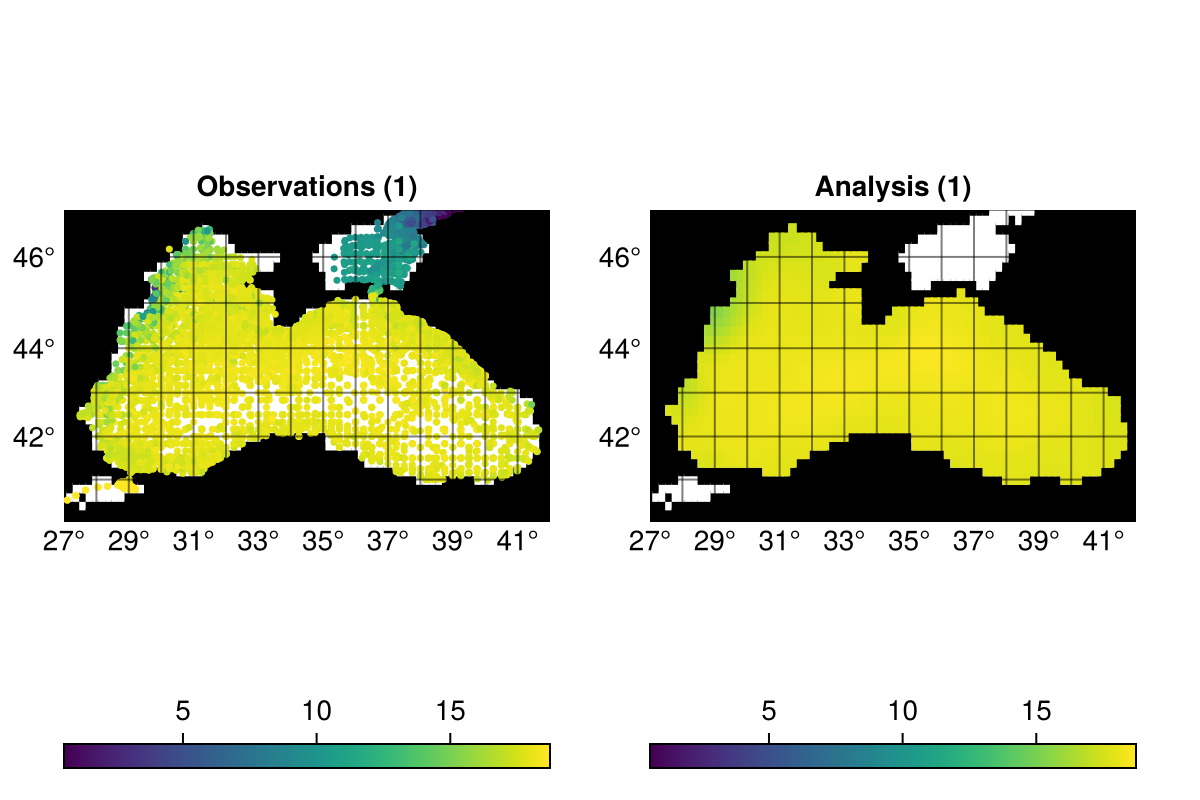

[ Info: Time step 2 / 8
[ Info: scaled correlation length (min,max) in dimension 1: (200000.0, 200000.0)
[ Info: scaled correlation length (min,max) in dimension 2: (200000.0, 200000.0)
[ Info: scaled correlation length (min,max) in dimension 3: (10.0, 13.333333333333334)
┌ Warning: resolution (20.0) is too coarse for correlation length 10.0 in dimension 3 at indices CartesianIndex(4, 3, 1) (skipping further tests). It is recommended that the resolution is at least 2 times finer than the correlation length.
└ @ DIVAnd ~/.julia/packages/DIVAnd/4UymR/src/utils.jl:18
[ Info: number of windows: 1


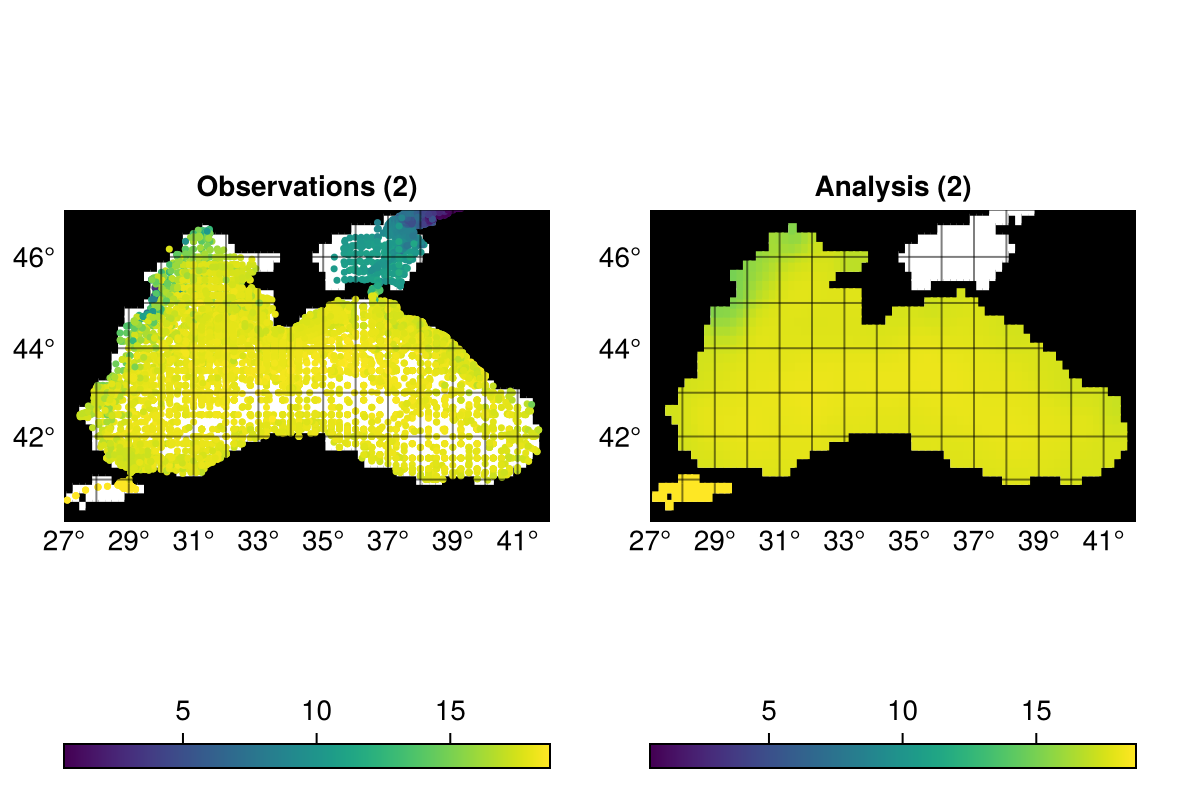

[ Info: Time step 3 / 8
[ Info: scaled correlation length (min,max) in dimension 1: (200000.0, 200000.0)
[ Info: scaled correlation length (min,max) in dimension 2: (200000.0, 200000.0)
[ Info: scaled correlation length (min,max) in dimension 3: (10.0, 13.333333333333334)
┌ Warning: resolution (20.0) is too coarse for correlation length 10.0 in dimension 3 at indices CartesianIndex(4, 3, 1) (skipping further tests). It is recommended that the resolution is at least 2 times finer than the correlation length.
└ @ DIVAnd ~/.julia/packages/DIVAnd/4UymR/src/utils.jl:18
[ Info: number of windows: 1


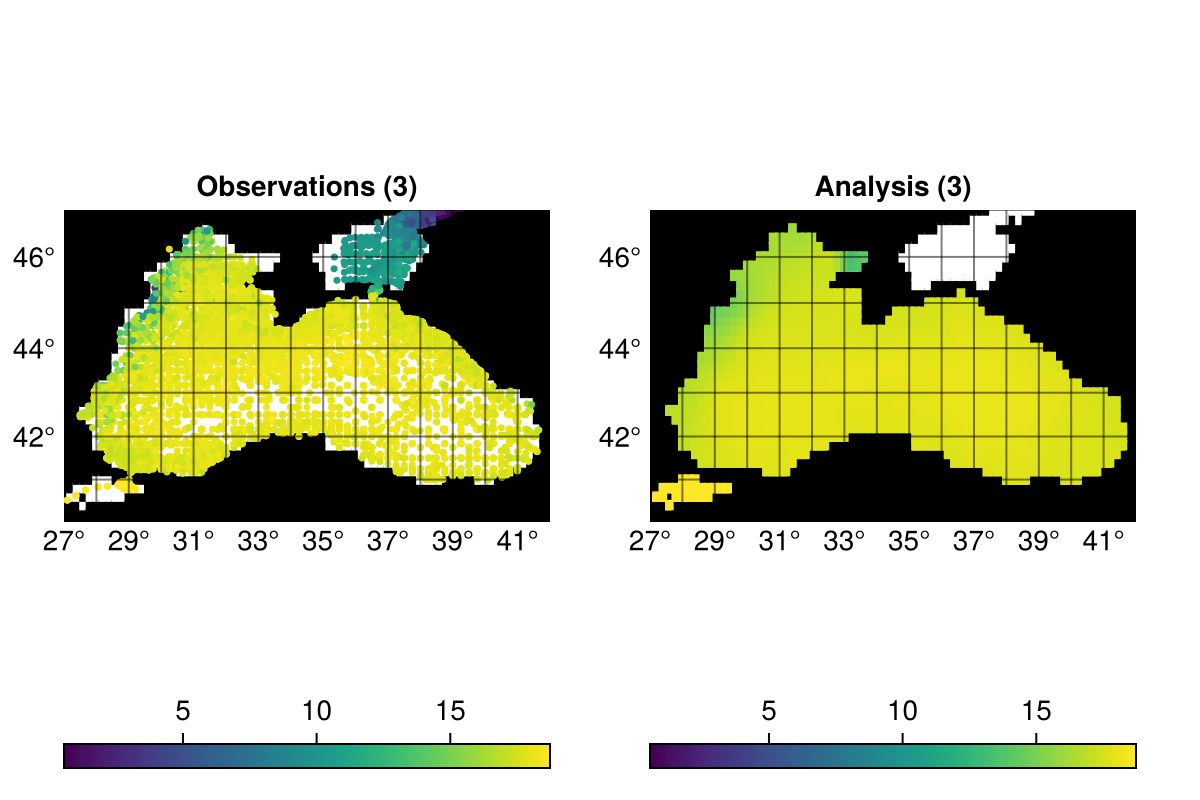

[ Info: Time step 4 / 8
[ Info: scaled correlation length (min,max) in dimension 1: (200000.0, 200000.0)
[ Info: scaled correlation length (min,max) in dimension 2: (200000.0, 200000.0)
[ Info: scaled correlation length (min,max) in dimension 3: (10.0, 13.333333333333334)
┌ Warning: resolution (20.0) is too coarse for correlation length 10.0 in dimension 3 at indices CartesianIndex(4, 3, 1) (skipping further tests). It is recommended that the resolution is at least 2 times finer than the correlation length.
└ @ DIVAnd ~/.julia/packages/DIVAnd/4UymR/src/utils.jl:18
[ Info: number of windows: 1


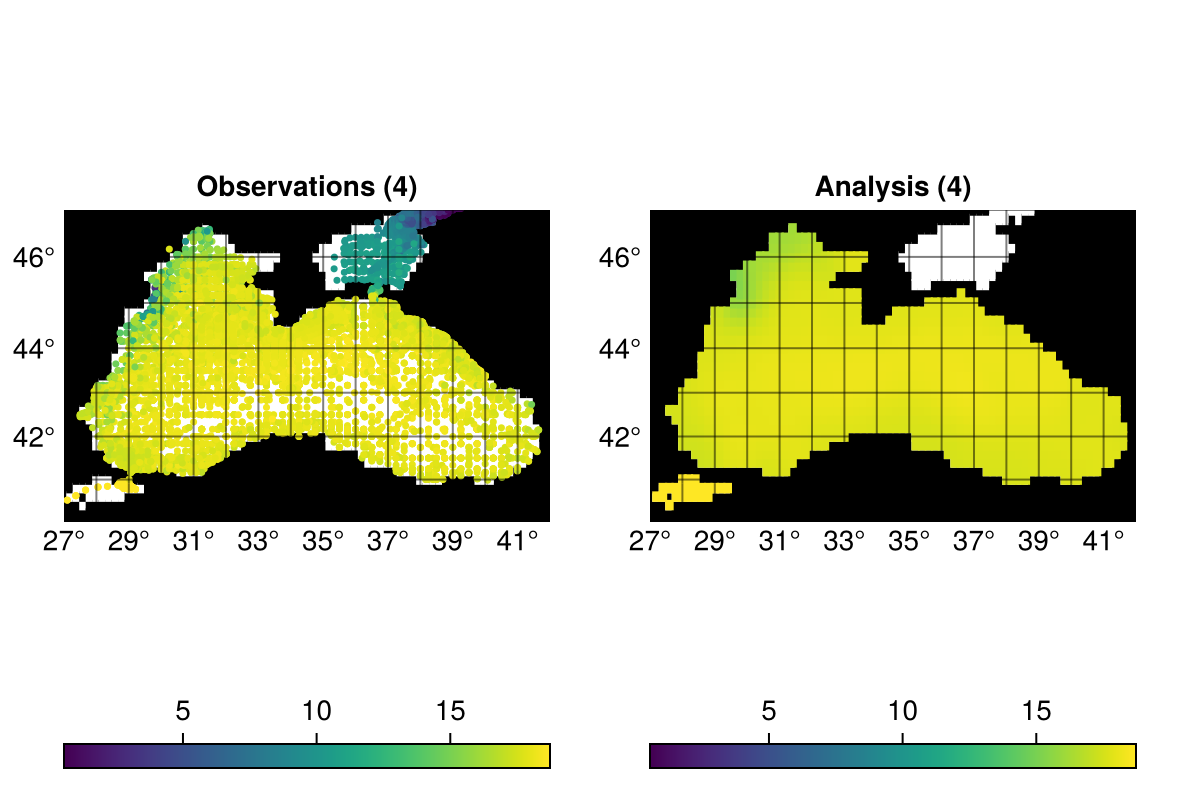

[ Info: Time step 5 / 8
[ Info: scaled correlation length (min,max) in dimension 1: (200000.0, 200000.0)
[ Info: scaled correlation length (min,max) in dimension 2: (200000.0, 200000.0)
[ Info: scaled correlation length (min,max) in dimension 3: (10.0, 13.333333333333334)
┌ Warning: resolution (20.0) is too coarse for correlation length 10.0 in dimension 3 at indices CartesianIndex(4, 3, 1) (skipping further tests). It is recommended that the resolution is at least 2 times finer than the correlation length.
└ @ DIVAnd ~/.julia/packages/DIVAnd/4UymR/src/utils.jl:18
[ Info: number of windows: 1


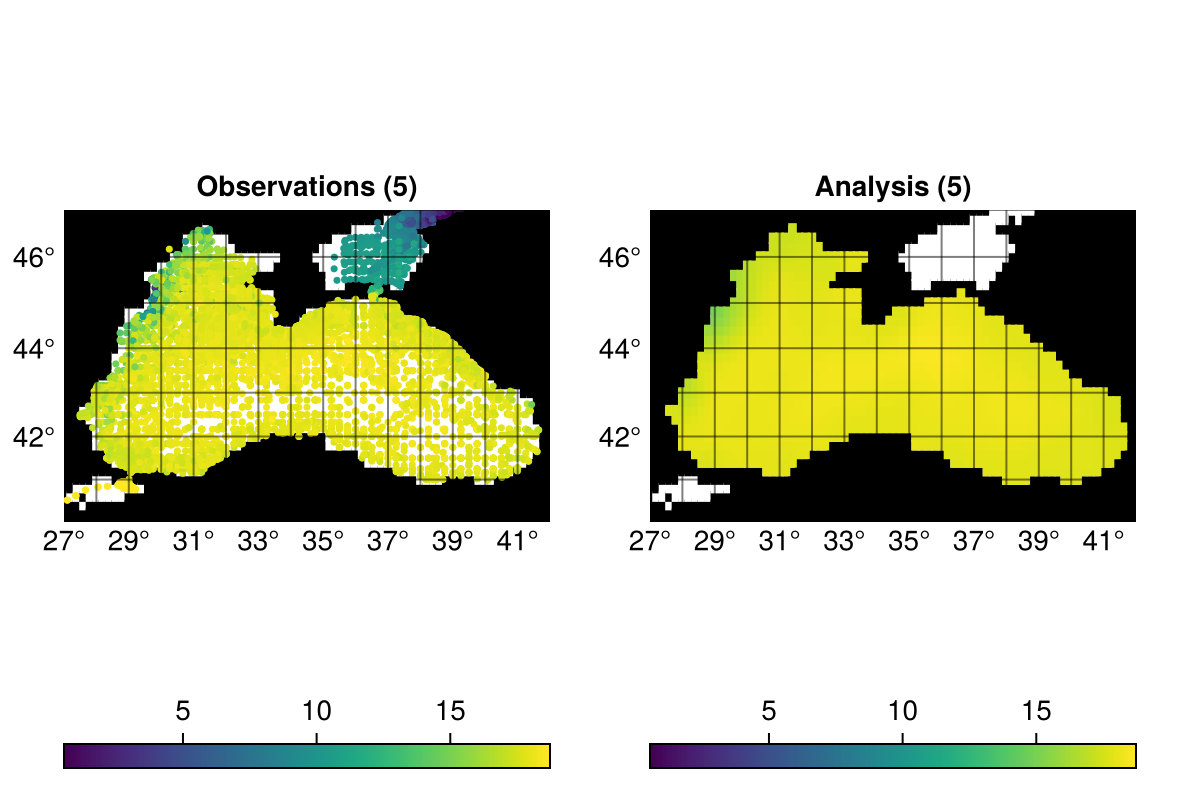

[ Info: Time step 6 / 8
[ Info: scaled correlation length (min,max) in dimension 1: (200000.0, 200000.0)
[ Info: scaled correlation length (min,max) in dimension 2: (200000.0, 200000.0)
[ Info: scaled correlation length (min,max) in dimension 3: (10.0, 13.333333333333334)
┌ Warning: resolution (20.0) is too coarse for correlation length 10.0 in dimension 3 at indices CartesianIndex(4, 3, 1) (skipping further tests). It is recommended that the resolution is at least 2 times finer than the correlation length.
└ @ DIVAnd ~/.julia/packages/DIVAnd/4UymR/src/utils.jl:18
[ Info: number of windows: 1


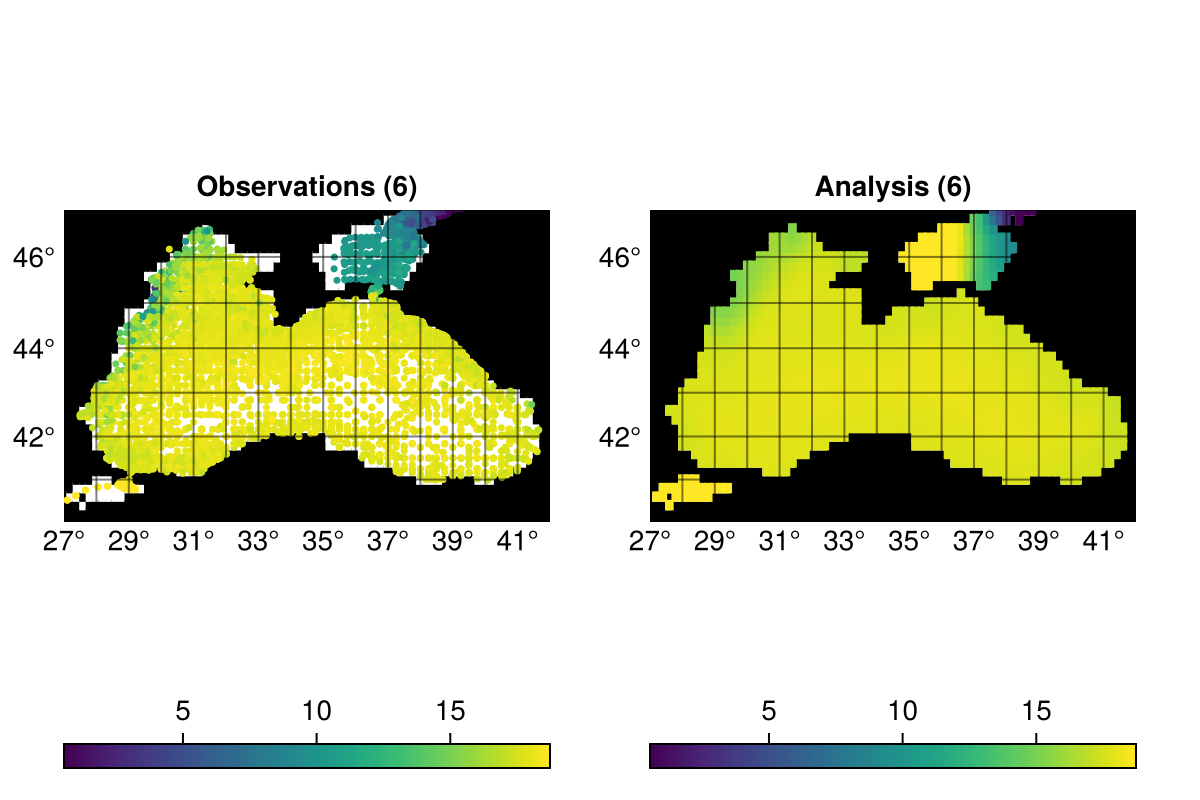

[ Info: Time step 7 / 8
[ Info: scaled correlation length (min,max) in dimension 1: (200000.0, 200000.0)
[ Info: scaled correlation length (min,max) in dimension 2: (200000.0, 200000.0)
[ Info: scaled correlation length (min,max) in dimension 3: (10.0, 13.333333333333334)
┌ Warning: resolution (20.0) is too coarse for correlation length 10.0 in dimension 3 at indices CartesianIndex(4, 3, 1) (skipping further tests). It is recommended that the resolution is at least 2 times finer than the correlation length.
└ @ DIVAnd ~/.julia/packages/DIVAnd/4UymR/src/utils.jl:18
[ Info: number of windows: 1


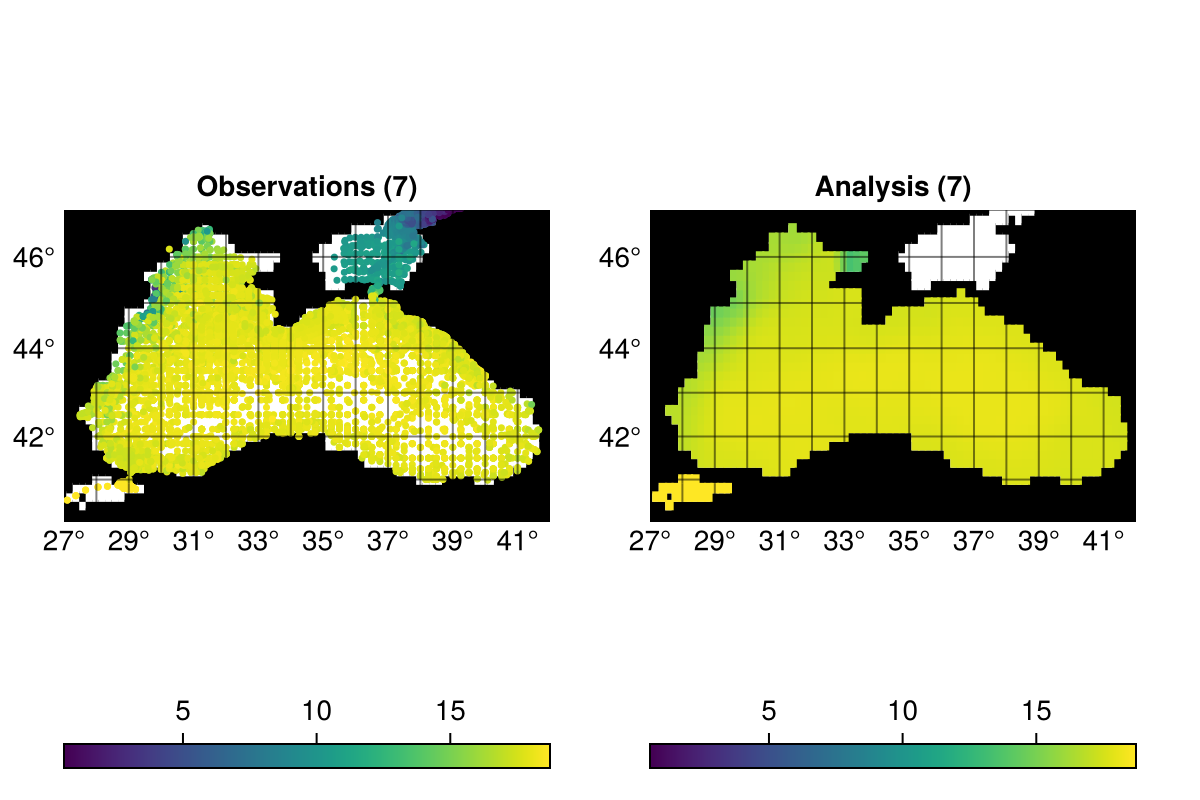

[ Info: Time step 8 / 8
[ Info: scaled correlation length (min,max) in dimension 1: (200000.0, 200000.0)
[ Info: scaled correlation length (min,max) in dimension 2: (200000.0, 200000.0)
[ Info: scaled correlation length (min,max) in dimension 3: (10.0, 13.333333333333334)
┌ Warning: resolution (20.0) is too coarse for correlation length 10.0 in dimension 3 at indices CartesianIndex(4, 3, 1) (skipping further tests). It is recommended that the resolution is at least 2 times finer than the correlation length.
└ @ DIVAnd ~/.julia/packages/DIVAnd/4UymR/src/utils.jl:18
[ Info: number of windows: 1


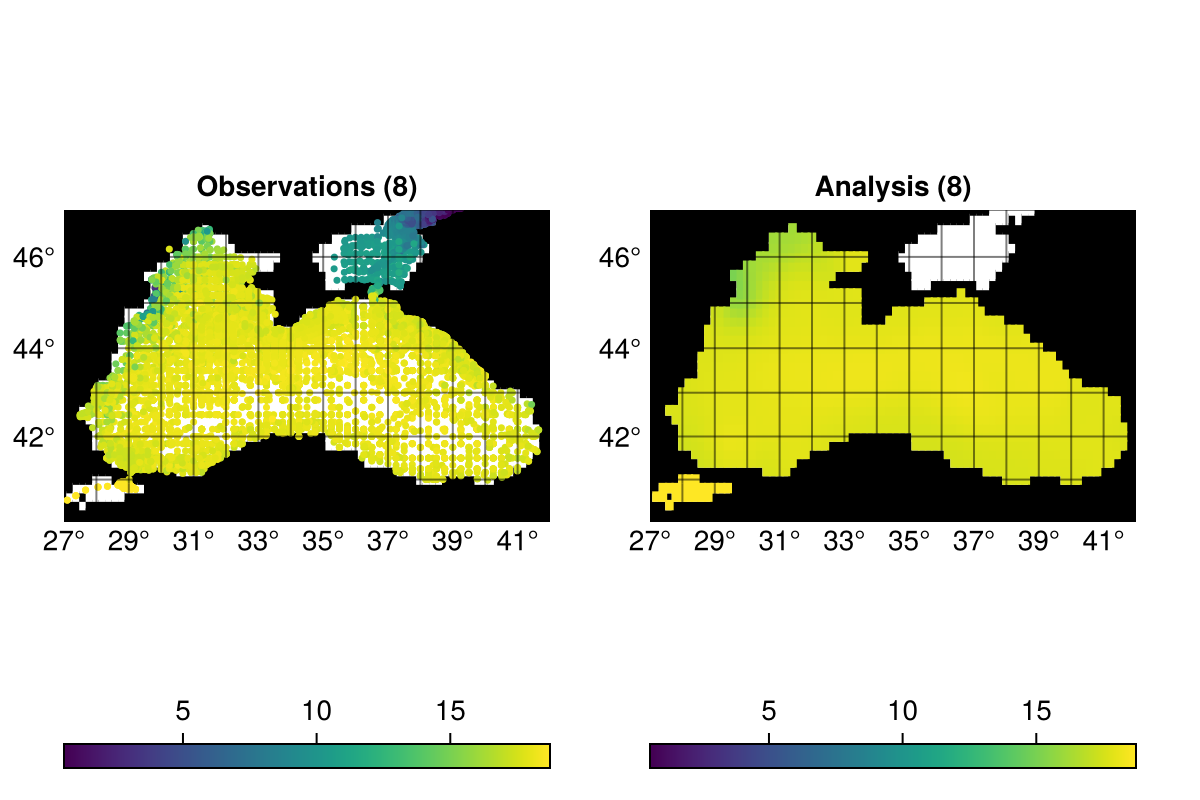

 60.501241 seconds (144.24 M allocations: 10.298 GiB, 10.79% gc time, 82.52% compilation time: 6% of which was recompilation)


Dict{Symbol, Any} with 5 entries:
  :used               => Bool[1, 1, 1, 1, 1, 1, 1, 1, 1, 0  …  0, 0, 0, 0, 0, 1…
  :residuals          => [-0.332331, -0.845101, -1.15787, -1.25124, 0.362611, 0…
  :mask               => Bool[0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0;;;…
  :factore            => [53.6704 49.6507 … 62.1989 28.9633]
  :background_profile => [18.188 17.8913 … 17.7859 18.1494; 18.2966 18.1488 … 1…

In [24]:
if isfile(filename)
    rm(filename) # delete the previous analysis
end

@time dbinfo = diva3d(
    (lonr, latr, depthr, TS),
    (obslon, obslat, obsdepth, obstime),
    obsval,
    (lenx, leny, lenz),
    epsilon2,
    filename,
    varname,
    bathname = bathname,
    bathisglobal = bathisglobal,
    plotres = plotres,
    ncvarattrib = ncvarattrib,
    ncglobalattrib = ncglobalattrib,
    timeorigin = timeorigin,
)

This generates many plots (one for every time instance).     
The number in the title is the time index starting with the first season and year.


### Save the observation metadata in the NetCDF file

In [25]:
DIVAnd.saveobs(filename, (obslon, obslat, obsdepth, obstime), obsid_mod)

## Residuals
The residuals are obtained from the structure `dbinfo`):

In [26]:
res = get(dbinfo, :residuals, 0)
@show extrema(res);

extrema(res) = (NaN, NaN)


Residuals with NaNs removed

In [27]:
res2 = res[.!isnan.(res)]

@show extrema(res2);
@show quantile(res2, [0.01, 0.99]);

extrema(res2) = (-10.440013885498047, 15.845908164978027)
quantile(res2, [0.01, 0.99]) = [-0.9080934596061706, 0.7474037677049636]


Get the identifier of the anomalous point (lowest residual):

In [28]:
i = findfirst(minimum(res2) .== res)
obsid[i]

"Cruise:WOD05_UA000106-11577843-29.7960-45.147"

For future analysis the residuals can also be saved.

In [29]:
resname = joinpath(outputdir, "Water_body_$(replace(varname, " "=>"_")).residuals.nc")
if isfile(resname)
    rm(resname)
end
DIVAnd.saveobs(
    resname,
    "$(varname)_residual",
    res,
    (obslon, obslat, obsdepth, obstime),
    obsid,
)

* Visualize the residuals (observations minus analysis)
* Change depth and time
* Adjust colorbare range (`clim`) to see large residuals

Number of data points: 1378

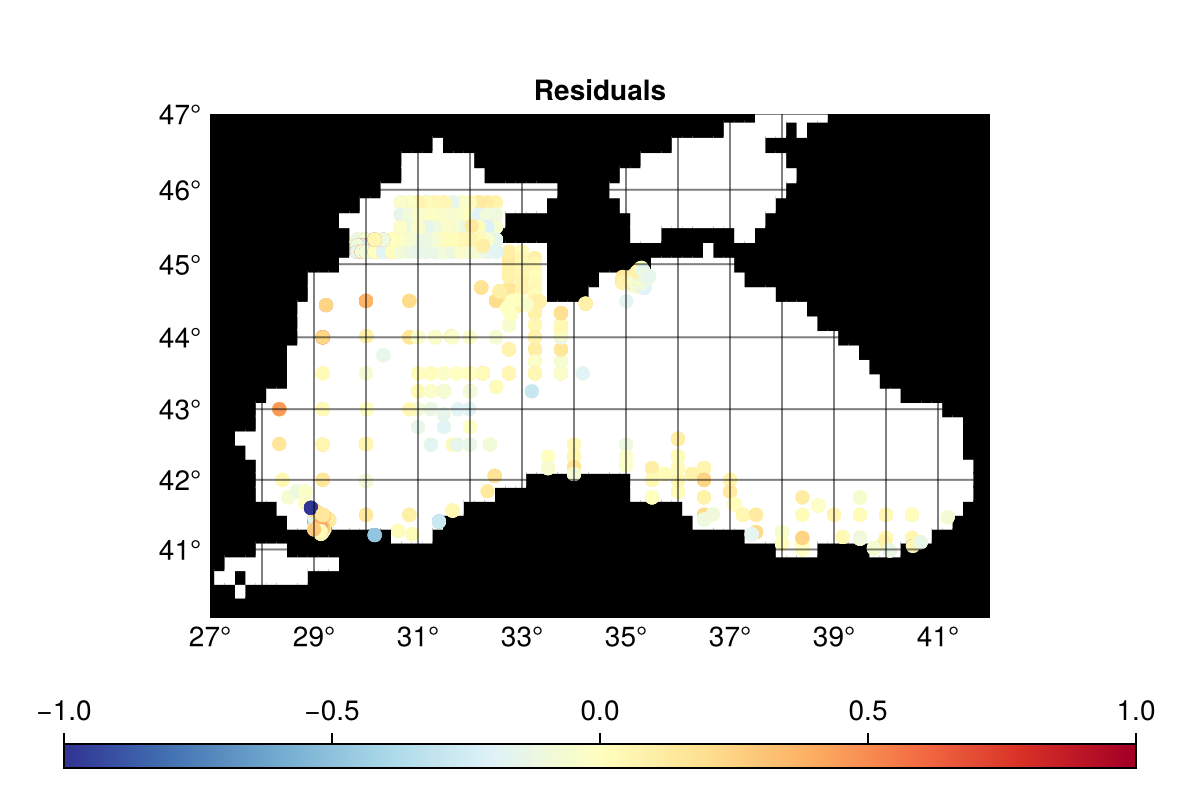

In [30]:
sel = (obsdepth .< 50) .& (Dates.month.(obstime) .== 1)
print("Number of data points: $(sum(sel))")

fig = Figure(size = (600, 400))
ga = GeoAxis(fig[1, 1]; dest = "+proj=merc", title = "Residuals")
heatmap!(ga, lonr, latr, mask, colormap = Reverse(:binary))
sc = scatter!(
    ga,
    obslon[sel],
    obslat[sel],
    color = res[sel],
    colormap = Reverse(:RdYlBu),
    markersize = 10,
    colorrange = [-1.0, 1.0],
)

xlims!(ga, (lonr[1], lonr[end]))
ylims!(ga, (latr[1], latr[end]))
Colorbar(fig[2, 1], sc, vertical = false)
fig